💈 Introduction aux réseaux de neurones artificiels



## Preamble



### Imports



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from seaborn.relational import lineplot
import os
from cycler import cycler
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from kerastuner import HyperModel, BayesianOptimization

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

print(f"TensorFlow Version: {tf.__version__}")

# Out[70]:

### Functions



In [1]:
# Display all
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 20): 
        display(df)

# Out[71]:

### Seaborn



In [1]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Out[73]:

## Load Data



In [1]:
X = load_breast_cancer()['data']
y = load_breast_cancer()['target']
feature_names = load_breast_cancer()['feature_names']
df = pd.DataFrame(X, columns=feature_names)

# Out[74]:

## Split the data



In [1]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)
x_train.shape, y_train.shape

# Out[75]:
((455, 30), (455,))

### Feature Scaling



In [1]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(x_train))

# Out[76]:

In [1]:
print(normalizer.mean.numpy())

# Out[77]:

## Tuning Hyperparameters



In [1]:
class ClassificationHyperModel(HyperModel):
    def __init__(self, input_shape, norm):
        self.input_shape = input_shape
        self.norm = norm
        
    def build(self, hp):
        model = Sequential()

        model.add(
            self.norm
        )

        model.add(
            Dense(
                units=hp.Int('units_1', 8, 64, 4, default=8),
                activation=hp.Choice(
                    'dense_activation_1',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=self.input_shape
            )
        )
        
        model.add(
            Dense(
                units=hp.Int('units_2', 16, 64, 4, default=16),
                activation=hp.Choice(
                    'dense_activation_2',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )
        
        model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    default=0.005,
                    step=0.01)
            )
        )
        
        model.add(Dense(2, activation='softmax'))

        lr = hp.Choice('learning_rate',
            values=[1e-1, 1e-2, 1e-3])
        opt = Adam(learning_rate=lr)
        
        model.compile(
            optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

# Out[78]:

In [1]:
input_shape = (x_train.shape[1],)
hypermodel = ClassificationHyperModel(input_shape, normalizer)

# Out[79]:

In [1]:
%%time
tuner_bo = BayesianOptimization(
    hypermodel,
    objective='accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=2,
    directory='model/kt',
    project_name='bcw'

)

tuner_bo.search(x_train, y_train, epochs=10, validation_split=0.2, verbose=0)
best_model = tuner_bo.get_best_models(num_models=1)[0]

# Out[80]:

In [1]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 30)               61        
 n)                                                              
                                                                 
 dense (Dense)               (None, 44)                1364      
                                                                 
 dense_1 (Dense)             (None, 36)                1620      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 74        
                                                                 
Total params: 3,119
Trainable params: 3,058
Non-trainable params: 61
_____________________________________________________

In [1]:
# Get the optimal hyperparameters
best_hps=tuner_bo.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')} and the optimal activation is {best_hps.get('dense_activation_1')}.
The optimal number of units in the second densely-connected
layer is {best_hps.get('units_2')} and the optimal activation is {best_hps.get('dense_activation_2')}.
The learning rate is {best_hps.get('learning_rate')}.
And the dropout is {best_hps.get('dropout')}
""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 44 and the optimal activation is relu.
The optimal number of units in the second densely-connected
layer is 36 and the optimal activation is tanh.
The learning rate is 0.1.
And the dropout is 0.09

-   Finally we fit our best model:



In [1]:
checkpoint_path = "model/bcw/checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              monitor='val_loss',
                              mode='min',
                              save_weights_only=True,
                              save_freq=50,
                              save_best_only=True,
                              verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = best_model.fit(x_train, 
                         y_train,
                         epochs=20,
                         batch_size=len(y_train),
                         validation_split=0.2,
                         callbacks=[cp_callback, es_callback]
)

# Out[83]:

## Evaluation



In [1]:
val_loss, val_accuracy = best_model.evaluate(x_train, y_train)
val_loss, val_accuracy

# Out[84]:
(0.058622051030397415, 0.9868132472038269)

# Out[85]:

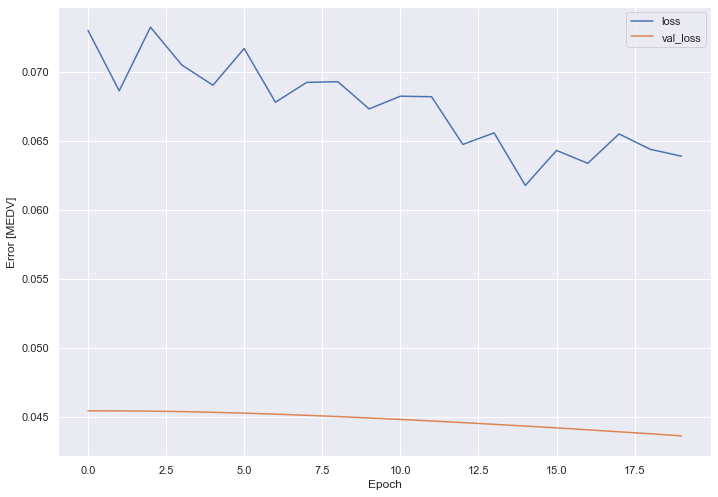

In [1]:
def plot_fit(history, metric):
  plt.plot(history.history[f'{metric}'], label=f'{metric}')
  plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MEDV]')
  plt.legend()
  plt.grid(True)
  
plot_fit(history, 'loss')

## Save best model



In [1]:
best_model.save('model/bcw')

# Out[86]:

## Bibliography



### References:PROPERTIES:




[tfk.bib](tfk.bib)

